# HGT Implementation

```
@misc{hu2020heterogeneous,
  added-at = {2020-08-27T23:30:32.000+0200},
  author = {Hu, Ziniu and Dong, Yuxiao and Wang, Kuansan and Sun, Yizhou},
  biburl = {https://www.bibsonomy.org/bibtex/20c4c17852fb0490cdd9d4299bac7e04e/yihong-liu},
  description = {Heterogeneous Graph Transformer},
  interhash = {a898c0dc2305e22504e4213ec94b3040},
  intrahash = {0c4c17852fb0490cdd9d4299bac7e04e},
  keywords = {#dl #embedding #ml},
  note = {cite arxiv:2003.01332Comment: Published on WWW 2020},
  timestamp = {2020-08-27T23:30:32.000+0200},
  title = {Heterogeneous Graph Transformer},
  url = {http://arxiv.org/abs/2003.01332},
  year = 2020
}
```

## Import Library

In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import os
import pandas as pd
import numpy as np
import torch
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn import HGTConv
from utils.startup_data_set import *
from utils.PredictorClasses import *
from utils.CustomMetrics import *
from utils.CustomUtilities import *
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [2]:
graph = COMP4222Dataset()
g = graph[0].to(device)

## Generate Postitve Graph and Negative Graph with Spliting

In [3]:
train_g, train_pos_g, val_pos_g, test_pos_g, *_ = generate_pos_graph(g)

In [4]:
train_g.ndata['feat']

tensor([[0.2000, 0.5556, 0.0143,  ..., 0.0000, 0.0000, 1.0000],
        [0.0667, 0.3333, 0.0118,  ..., 0.0000, 0.0000, 1.0000],
        [0.3333, 0.0000, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0019, 0.0023, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0095, 0.0113, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0019, 0.0023, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', dtype=torch.float64)

In [5]:
train_neg_g, val_neg_g, test_neg_g = generate_neg_graph(g)

(17852, 25446)


In [6]:
train_g, train_pos_g, val_pos_g, test_pos_g = train_g.to(device), train_pos_g.to(device), val_pos_g, test_pos_g.to(device)
train_neg_g, val_neg_g, test_neg_g = train_neg_g.to(device), val_neg_g.to(device), test_neg_g.to(device)
num_nodes = g.num_nodes
num_edges = g.num_edges

## Hyperparameters

In [7]:
in_size  = train_g.ndata["feat"].shape[1]
head_size  = 16
num_ntypes  = 2
num_etypes  = 1
dropout  = 0.2
use_norm  = False
num_heads = 4

## Model Training

### Model Setup

In [8]:
hgt_model = HGTConv(in_size  = in_size,
                                head_size  =  head_size,
                                num_heads  = num_heads,
                                num_ntypes  = num_ntypes,
                                num_etypes  = num_etypes,
                                dropout = dropout,
                                use_norm = use_norm ).to(device)

In [9]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(2*h_feats , h_feats).to(torch.float32)
        self.W2 = nn.Linear(h_feats, 1).to(torch.float32)

    # concat the source and destination node, use mlp to predict the score
    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1).to(torch.float32)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h.to(torch.float32)
            g.apply_edges(self.apply_edges)
            return g.edata['score']


pred = MLPPredictor(64).to(device)
early_stopping = 10


### Training Loop

In [10]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0
ep = 101
optimizer = torch.optim.Adam(itertools.chain(hgt_model.parameters(), pred.parameters()))
etype = torch.tensor([i % 1 for i in range(train_g.num_edges())]).to(device)
ntype = train_g.ndata["label"].to(torch.long)
for e in range(ep):
    # forward
    h = hgt_model(train_g, train_g.ndata['feat'].to(torch.float32),ntype ,etype).to(device)
    pos_score = pred(train_pos_g.to(device),h.to(device))
    neg_score = pred(train_neg_g.to(device),h.to(device))
    # update 
    
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 10 == 0:
        print('Epoch: {} \t Train loss: {} \t Val loss: {} \t Train AUC: {} \t Val AUC: {}'.format(e, round(loss.item(), 3), round(v_loss.item(), 3), round(train_AUC[-1],3), round(val_AUC[-1], 3)))


    # early stopping
    if e > 10:
        if v_loss.item() > sum(val_loss[-5:])/5:
            stop += 1
        else: 
            stop = 0
        if stop >= early_stopping:
            print("Early Stopped at Epoch {}".format(e))
            break


Epoch: 0 	 Train loss: 0.696 	 Val loss: 0.695 	 Train AUC: 0.41 	 Val AUC: 0.497
Epoch: 10 	 Train loss: 0.683 	 Val loss: 0.682 	 Train AUC: 0.912 	 Val AUC: 0.905
Epoch: 20 	 Train loss: 0.636 	 Val loss: 0.634 	 Train AUC: 0.935 	 Val AUC: 0.925
Epoch: 30 	 Train loss: 0.471 	 Val loss: 0.473 	 Train AUC: 0.944 	 Val AUC: 0.93
Epoch: 40 	 Train loss: 0.294 	 Val loss: 0.338 	 Train AUC: 0.949 	 Val AUC: 0.933
Epoch: 50 	 Train loss: 0.264 	 Val loss: 0.384 	 Train AUC: 0.945 	 Val AUC: 0.928
Early Stopped at Epoch 52


In [11]:
recommend_pos_dict = generate_recommend_dict(dgl.remove_self_loop(train_pos_g),pos_score)

torch.Size([36497])


In [12]:
recommend_pos_dict

{0: [[20586, 2.9648704528808594], [20935, 2.7964437007904053]],
 2: [[24220, 3.576237916946411],
  [24200, 2.503196954727173],
  [24182, 2.8868255615234375],
  [22079, 3.6511452198028564]],
 4: [[19580, 2.637455701828003],
  [22705, 2.821657657623291],
  [22999, 3.268965721130371],
  [25010, 2.3538403511047363]],
 7: [[23385, 2.528970241546631]],
 8: [[22059, 2.5401294231414795]],
 10: [[20915, 3.3814332485198975]],
 12: [[20138, 2.4075021743774414],
  [19026, 2.3258540630340576],
  [22607, 2.4303579330444336]],
 15: [[22635, 3.0117099285125732],
  [19156, 3.401808977127075],
  [22705, 3.000624179840088]],
 16: [[25238, 3.331637144088745]],
 17: [[24103, 2.1306347846984863]],
 23: [[20016, 3.3166356086730957], [19764, 2.163439989089966]],
 25: [[20570, 2.4205617904663086],
  [22059, 3.1557912826538086],
  [19542, 3.5305416584014893]],
 27: [[19261, 2.7044119834899902]],
 28: [[18498, 2.322767972946167]],
 29: [[24220, 3.1025402545928955]],
 30: [[21099, 3.304197072982788],
  [22267, 3.

In [34]:
li = recommend_pos_dict[list(recommend_pos_dict.keys())[2]]
print(sorted(li,key=lambda l:l[1], reverse=True))
print(torch.sum(train_pos_g.edges()[0]==list(recommend_pos_dict.keys())[2]).item())

[[22999, 3.268965721130371], [22705, 2.821657657623291], [19580, 2.637455701828003], [25010, 2.3538403511047363]]
4


In [35]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.9314721463412853


In [38]:
recommend_pos_dict = generate_recommend_dict(dgl.remove_self_loop(test_pos_g),pos_score)
li = recommend_pos_dict[list(recommend_pos_dict.keys())[1]]
print(sorted(li,key=lambda l:l[1], reverse=True))
print(torch.sum(train_pos_g.edges()[0]==list(recommend_pos_dict.keys())[1]).item())

torch.Size([4562])
[[19781, 2.462972402572632], [22078, 2.03230619430542]]
2


### Result Plotting

Text(0, 0.5, 'Loss')

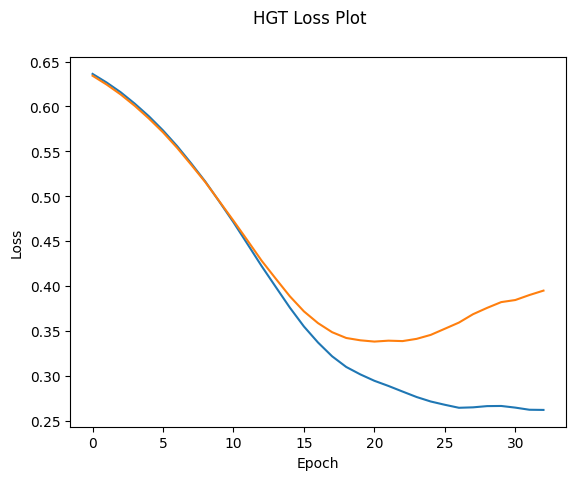

In [15]:
fig = plt.figure()
plt.plot(train_loss[20:], label='training loss')
plt.plot(val_loss[20:], label = 'validation loss')
fig.suptitle('HGT Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'AUC')

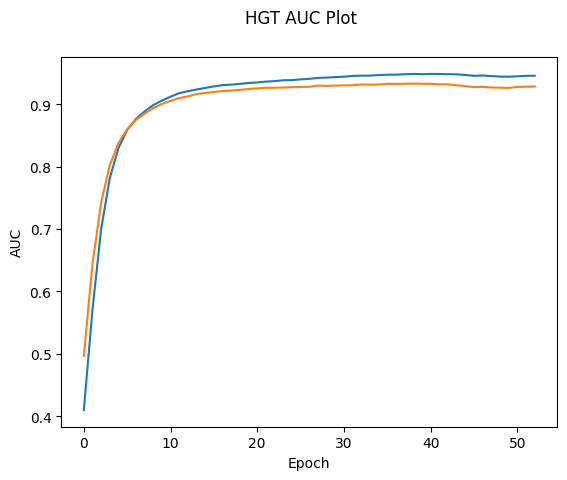

In [16]:
fig = plt.figure()
plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('HGT AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')